In [1]:
# Cell 0: 모듈 import를 위한 경로 설정
import os, sys
sys.path.append(os.path.abspath(".."))  # shared, models 디렉토리 접근 가능하도록 경로 추가

import os
print(os.getcwd())  # 현재 작업 디렉토리 출력


/caefs/user/mmingyeong/_dm2ics_model_benchmark/dm2ics_model_benchmark/evaluation


In [2]:
import os
import h5py
import numpy as np
import logging
from analyzer import PowerSpectrumAnalyzer  # 사용 중인 클래스 그대로 유지

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

# 경로 설정
input_file = "/caefs/data/IllustrisTNG/subcube/input/subcubes_stride4_50mpc_010.h5"
target_file = "/caefs/data/IllustrisTNG/subcube/output/subcubes_stride4_50mpc_010.h5"
prediction_file = "/caefs/data/IllustrisTNG/predictions/unet/Sample100_epoch100/subcubes_stride4_50mpc_010.h5"
eval_dir = "vit_eval_res"
model_name = "vit"
axis = 0
index = 42

# 단일 subcube만 로드
def load_single_cube(file_path, index, pred=False):
    with h5py.File(file_path, 'r') as f:
        key = list(f.keys())[0]
        if pred:
            return np.array(f[key][index, 0])  # (N, N, N)
        else:
            return np.array(f[key][index])     # (N, N, N)

# 데이터 불러오기
logging.info(f"📥 Loading subcube index {index}")
input_cube = load_single_cube(input_file, index)
gt_cube = load_single_cube(target_file, index)
pred_cube = load_single_cube(prediction_file, index, pred=True)

2025-07-31 15:19:54,703 [INFO] 📥 Loading subcube index 42


2025-07-31 15:19:58,125 [INFO] Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-07-31 15:19:58,126 [INFO] NumExpr defaulting to 8 threads.
2025-07-31 15:19:58,338 [INFO] 📂 Loading log file: /home/users/mmingyeong/_dm2ics_model_benchmark/dm2ics_model_benchmark/results/vit_test/vit_full_3dreg_sample1_epoch30_log_train.csv
2025-07-31 15:19:58,342 [INFO] ✅ Log file loaded with shape (30, 4)


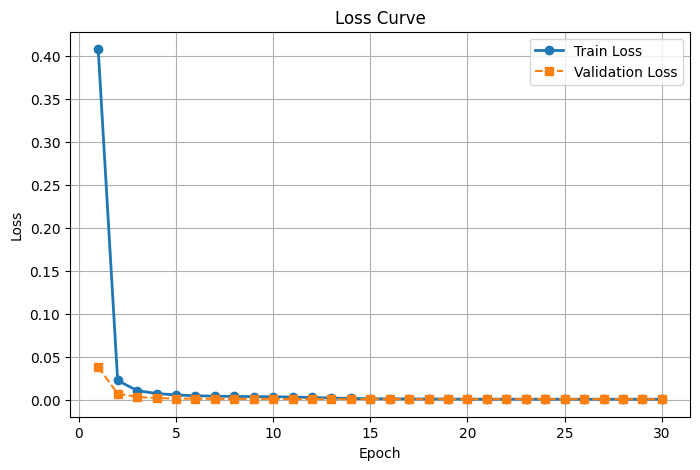

2025-07-31 15:19:58,602 [INFO] 📈 Loss curve saved to: /home/users/mmingyeong/_dm2ics_model_benchmark/dm2ics_model_benchmark/evaluation/vit_eval_res/loss_curve.png


In [3]:
# loss_curve_plot.py

import os
import logging
import pandas as pd
import matplotlib.pyplot as plt

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

def plot_loss_curve(log_csv_path, output_dir=None):
    """
    Plot training and validation loss curves from a CSV log file.

    Parameters
    ----------
    log_csv_path : str
        Path to the training log CSV file.
    output_dir : str, optional
        Directory to save the output loss curve plot. If None, saves to the CSV file directory.
    """
    logging.info(f"📂 Loading log file: {log_csv_path}")
    
    if not os.path.exists(log_csv_path):
        logging.error(f"❌ File not found: {log_csv_path}")
        return
    
    df = pd.read_csv(log_csv_path)
    logging.info(f"✅ Log file loaded with shape {df.shape}")

    # 필수 열 확인
    required_columns = ['epoch', 'train_loss']
    if not all(col in df.columns for col in required_columns):
        logging.error(f"❌ Required columns {required_columns} not found in CSV.")
        return

    # 그래프 출력
    plt.figure(figsize=(8, 5))
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss', linewidth=2, marker='o')

    if 'val_loss' in df.columns:
        plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', linestyle='--', marker='s')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)

    # 저장 경로 설정
    if output_dir is None:
        output_dir = os.path.dirname(log_csv_path)
    os.makedirs(output_dir, exist_ok=True)
    
    save_path = os.path.join(output_dir, "loss_curve.png")
    plt.show()
    plt.savefig(save_path)
    plt.close()
    
    logging.info(f"📈 Loss curve saved to: {save_path}")

# 실행 예시
if __name__ == "__main__":
    log_file = "/home/users/mmingyeong/_dm2ics_model_benchmark/dm2ics_model_benchmark/results/vit_test/vit_full_3dreg_sample1_epoch30_log_train.csv"
    output_dir = "/home/users/mmingyeong/_dm2ics_model_benchmark/dm2ics_model_benchmark/evaluation/vit_eval_res"
    plot_loss_curve(log_file, output_dir)


In [4]:
def plot_projection_comparison(input_cube, gt_cube, pred_cube, axis=0, index=None,
                                model_name="U-Net", save_dir=None, show=False):
    """
    Compare projections of input, ground truth, and prediction cubes along a given axis.
    All projections are visualized using log1p scaling.

    Parameters
    ----------
    input_cube : np.ndarray
        The evolved density cube.
    gt_cube : np.ndarray
        The initial condition (ground truth) cube.
    pred_cube : np.ndarray
        The model-predicted initial condition cube.
    axis : int, optional
        Axis along which to project (default=0).
    index : int, optional
        Index of the subcube for annotation.
    model_name : str
        Model name used in title.
    save_dir : str
        Directory to save the output plot.
    show : bool
        If True, also show the plot inline.
    """
    # Projection
    input_proj = np.sum(input_cube, axis=axis)
    gt_proj = np.sum(gt_cube, axis=axis)
    pred_proj = np.sum(pred_cube, axis=axis)

    # Apply log scaling to all
    input_proj = np.log1p(input_proj)
    gt_proj = np.log1p(gt_proj)
    pred_proj = np.log1p(pred_proj)

    projections = [input_proj, gt_proj, pred_proj]
    titles = [
        "Input (log(1 + projected density))",
        "Ground Truth (log(1 + projected density))",
        f"{model_name} Prediction (log(1 + projected density))"
    ]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, (proj, title) in enumerate(zip(projections, titles)):
        im = axs[i].imshow(proj, origin="lower", cmap="viridis")
        axs[i].set_title(title, fontsize=13)
        axs[i].set_xlabel("X [voxel] (1 voxel = 0.82 Mpc/h)", fontsize=11)
        axs[i].set_ylabel("Y [voxel] (1 voxel = 0.82 Mpc/h)", fontsize=11)
        cbar = fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
        cbar.set_label("log(1 + Projected Density)", fontsize=10)

    info_str = f"Projection axis = {axis} | Subcube index = {index} | Model = {model_name}"
    plt.suptitle(info_str, fontsize=15, y=1.1)
    plt.tight_layout()

    # Save
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        filename = f"{model_name.lower()}_projection_idx{index}_axis{axis}.png"
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        logging.info(f"📸 Saved projection comparison to {save_path}")

    if show:
        plt.show()
    else:
        plt.close()


2025-07-31 15:20:00,117 [INFO] 📸 Saved projection comparison to vit_eval_res/vit_projection_idx42_axis0.png


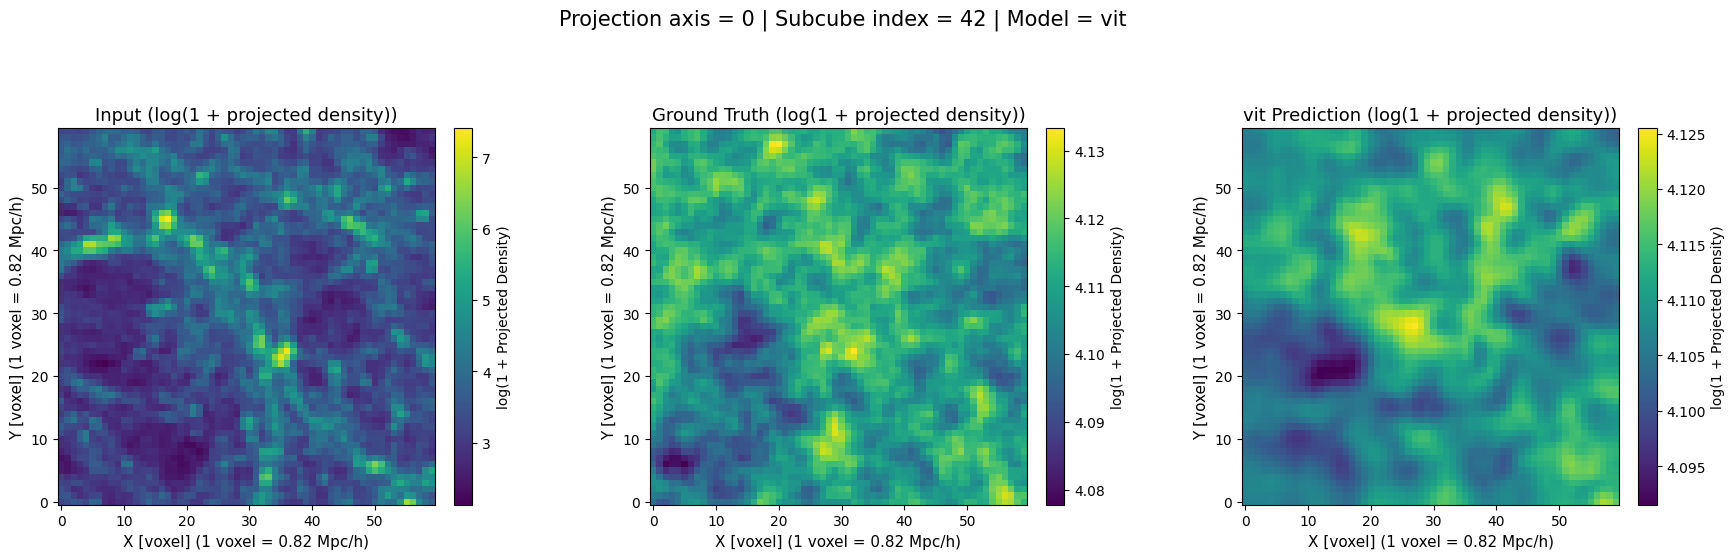

In [5]:


# 시각화
plot_projection_comparison(
    input_cube=input_cube,
    gt_cube=gt_cube,
    pred_cube=pred_cube,
    axis=axis,
    index=index,
    model_name=model_name,
    save_dir=eval_dir,
    show=True  # 클러스터일 경우 False로 설정
)


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import logging

def plot_pixel_scatter(y_true, y_pred, index=None, model_name="U-Net", save_dir=None, log_transform=True, show=False):
    """
    Plot a pixel-to-pixel scatter plot comparing predicted vs ground truth densities.

    Parameters
    ----------
    y_true : np.ndarray
        Ground truth density field.
    y_pred : np.ndarray
        Predicted density field.
    index : int, optional
        Subcube index for labeling.
    model_name : str
        Name of the model used (e.g., U-Net, ViT).
    save_dir : str
        Directory to save the plot.
    log_transform : bool
        Whether to apply log1p to values before plotting.
    show : bool
        Whether to display the plot inline.
    """
    if log_transform:
        y_true = np.log1p(y_true)
        y_pred = np.log1p(y_pred)

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_true_flat, y_pred_flat, s=1, alpha=0.3, color='royalblue', edgecolors='none')
    ax.plot([y_true_flat.min(), y_true_flat.max()], [y_true_flat.min(), y_true_flat.max()], 'r--', linewidth=1.5)

    ax.set_xlabel("Ground Truth (log(1 + δ))", fontsize=12)
    ax.set_ylabel(f"{model_name} Prediction (log(1 + δ))", fontsize=12)
    ax.set_title(f"Pixel-to-Pixel Comparison (Subcube index {index})", fontsize=13)
    ax.grid(True)

    # Save
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        filename = f"{model_name.lower()}_scatter_idx{index}.png"
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path, dpi=150)
        logging.info(f"📉 Saved scatter plot to {save_path}")

    if show:
        plt.show()
    else:
        plt.close()


2025-07-31 15:20:05,690 [INFO] 📉 Saved scatter plot to vit_eval_res/unet_scatter_idx42.png


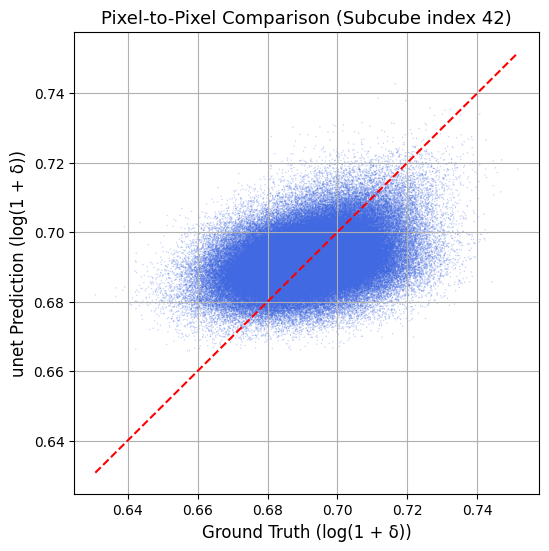

In [7]:
# 데이터 불러오기 (이전과 동일)
index = 42
y_true = load_single_cube(target_file, index)
y_pred = load_single_cube(prediction_file, index, pred=True)

# 시각화
plot_pixel_scatter(
    y_true=y_true,
    y_pred=y_pred,
    index=index,
    model_name="unet",
    save_dir=eval_dir,
    log_transform=True,
    show=True
)


2025-07-31 15:20:08,403 [INFO] field: ArrayMesh() painting done
[ 000000.05 ]   0: 07-31 15:20  MeshSource      INFO     field: ArrayMesh() painting done
2025-07-31 15:20:08,460 [INFO] field: ArrayMesh() painting done
[ 000000.11 ]   0: 07-31 15:20  MeshSource      INFO     field: ArrayMesh() painting done
2025-07-31 15:20:08,501 [INFO] field: ArrayMesh() painting done
[ 000000.15 ]   0: 07-31 15:20  MeshSource      INFO     field: ArrayMesh() painting done
2025-07-31 15:20:08,506 [INFO] field: ArrayMesh() painting done
[ 000000.15 ]   0: 07-31 15:20  MeshSource      INFO     field: ArrayMesh() painting done
/caefs/user/mmingyeong/_dm2ics_model_benchmark/dm2ics_model_benchmark/evaluation/nbodykit_analyzer.py:49: RuntimeWarning: invalid value encountered in true_divide
  self.T_k = self.P_pred / self.P_true
/caefs/user/mmingyeong/_dm2ics_model_benchmark/dm2ics_model_benchmark/evaluation/nbodykit_analyzer.py:50: RuntimeWarning: invalid value encountered in true_divide
  self.C_k = self.P

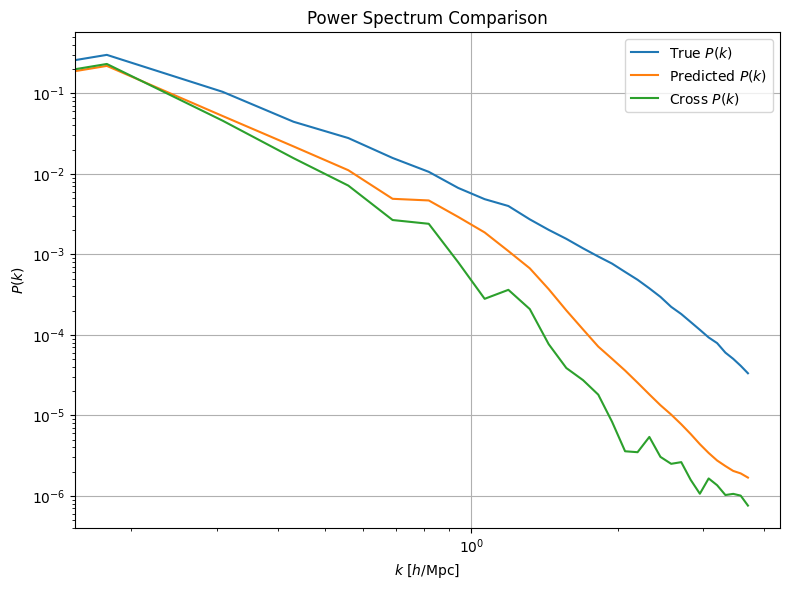

📊 Saved power spectrum to: vit_eval_res/power_spectrum_comparison.png


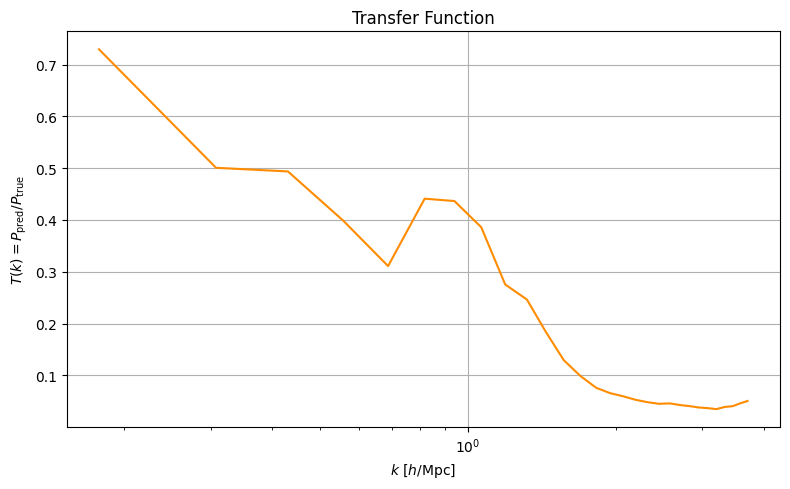

📈 Saved transfer function to: vit_eval_res/transfer_function.png


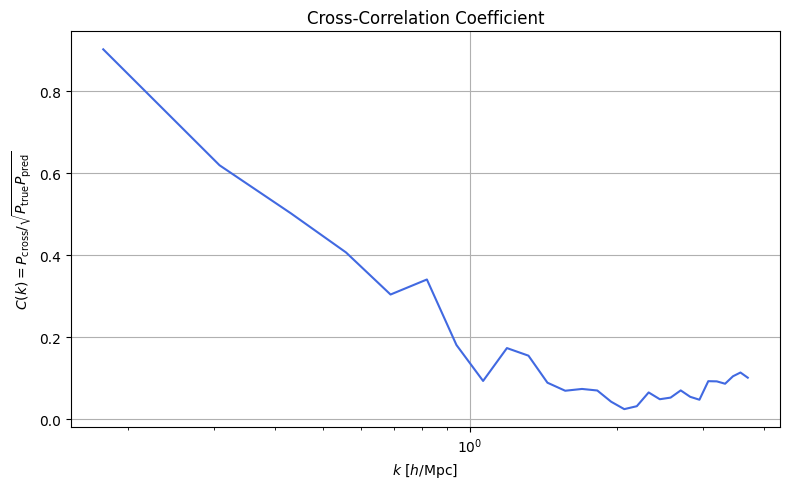

🔗 Saved correlation coefficient to: vit_eval_res/correlation_coefficient.png
✅ All analysis completed. Results saved to: vit_eval_res


In [8]:
import sys
from nbodykit_analyzer import DensityFieldAnalyzer  # 사전에 정의된 클래스

# 박스 사이즈 설정 (단위: Mpc/h)
box_size = 50.0

# DensityFieldAnalyzer 실행
analyzer = DensityFieldAnalyzer(
    true_density=gt_cube,
    pred_density=pred_cube,
    box_size=box_size,
    output_dir=eval_dir  # 예: _dm2ics_model_benchmark/dm2ics_model_benchmark/evaluation/vit_eval_res
)

analyzer.run_all()


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import logging

def analyze_gaussianity(y_true, y_pred, index=None, model_name="U-Net",
                        save_dir="./", log_transform=True, bins=100, show=False):
    """
    Analyze the Gaussianity of predicted vs true 3D fields using histograms and statistical moments.

    Parameters
    ----------
    y_true : np.ndarray
        Ground truth field (3D array).
    y_pred : np.ndarray
        Predicted field (3D array).
    index : int, optional
        Subcube index for labeling.
    model_name : str
        Model name to annotate plot.
    save_dir : str
        Directory to save plots.
    log_transform : bool
        If True, apply log1p before histogram.
    bins : int
        Number of histogram bins.
    show : bool
        Whether to show the plot inline.
    """
    if log_transform:
        y_true = np.log1p(y_true)
        y_pred = np.log1p(y_pred)
        suffix = "log1p"
    else:
        suffix = "linear"

    # Flatten data
    true_flat = y_true.flatten()
    pred_flat = y_pred.flatten()

    # Compute stats
    true_skew, true_kurt = stats.skew(true_flat), stats.kurtosis(true_flat)
    pred_skew, pred_kurt = stats.skew(pred_flat), stats.kurtosis(pred_flat)

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(true_flat, bins=bins, density=True, alpha=0.6, label=f"True ({suffix})")
    plt.hist(pred_flat, bins=bins, density=True, alpha=0.6, label=f"Predicted ({suffix})")

    # Fit normal distribution for reference
    x_range = np.linspace(min(true_flat.min(), pred_flat.min()), max(true_flat.max(), pred_flat.max()), 200)
    plt.plot(x_range, stats.norm.pdf(x_range, loc=np.mean(true_flat), scale=np.std(true_flat)),
             'k--', label='Normal Fit (True)')

    plt.xlabel(f"Voxel Value ({suffix})")
    plt.ylabel("Probability Density")
    plt.title(f"Voxel Value Distribution\n[Skewness] True: {true_skew:.2f}, Pred: {pred_skew:.2f} | [Kurtosis] True: {true_kurt:.2f}, Pred: {pred_kurt:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    filename = f"{model_name.lower()}_gaussianity_idx{index}_{suffix}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=150)
    logging.info(f"📊 Gaussianity plot saved to: {save_path}")

    if show:
        plt.show()
    else:
        plt.close()


2025-07-31 15:20:10,896 [INFO] 📊 Gaussianity plot saved to: vit_eval_res/vit_gaussianity_idx42_log1p.png
[ 000002.54 ]   0: 07-31 15:20  root            INFO     📊 Gaussianity plot saved to: vit_eval_res/vit_gaussianity_idx42_log1p.png


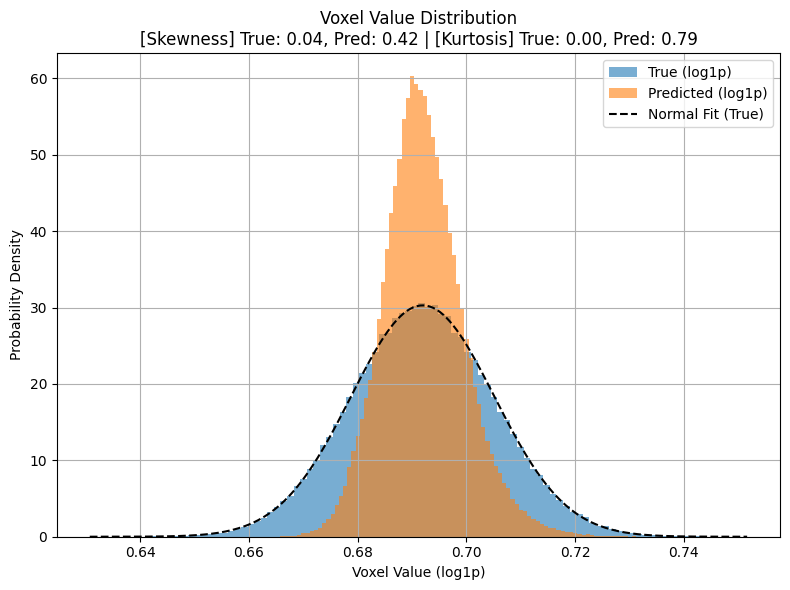

In [10]:
analyze_gaussianity(
    y_true=gt_cube,
    y_pred=pred_cube,
    index=index,
    model_name=model_name,
    save_dir=eval_dir,
    log_transform=True,  # log1p 스케일 기준
    show=True
)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
import logging

def compare_voxel_pdf(y_true, y_pred, index=None, model_name="U-Net",
                      save_dir="./", log_transform=True, bins=100, show=False):
    """
    Compare the probability density functions (PDF) of voxel values in true vs predicted fields.

    Parameters
    ----------
    y_true : np.ndarray
        Ground truth 3D field.
    y_pred : np.ndarray
        Predicted 3D field.
    index : int
        Subcube index for labeling.
    model_name : str
        Name of the model (used for plot labeling).
    save_dir : str
        Directory to save output plot.
    log_transform : bool
        Whether to apply log1p to the data before PDF computation.
    bins : int
        Number of bins if histogram is used (not KDE).
    show : bool
        Whether to display plot inline.
    """
    if log_transform:
        y_true = np.log1p(y_true)
        y_pred = np.log1p(y_pred)
        suffix = "log1p"
    else:
        suffix = "linear"

    true_flat = y_true.flatten()
    pred_flat = y_pred.flatten()

    # KDE 기반 PDF 추정
    kde_true = gaussian_kde(true_flat)
    kde_pred = gaussian_kde(pred_flat)

    xmin = min(true_flat.min(), pred_flat.min())
    xmax = max(true_flat.max(), pred_flat.max())
    x_vals = np.linspace(xmin, xmax, 500)

    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, kde_true(x_vals), label=f"True ({suffix})", linewidth=2)
    plt.plot(x_vals, kde_pred(x_vals), label=f"Predicted ({suffix})", linewidth=2, linestyle="--")
    plt.fill_between(x_vals, kde_true(x_vals), alpha=0.2, color='tab:blue')
    plt.fill_between(x_vals, kde_pred(x_vals), alpha=0.2, color='tab:orange')

    plt.xlabel(f"Voxel Value ({suffix})")
    plt.ylabel("Probability Density")
    plt.title(f"Voxel PDF Comparison (Subcube index {index})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    os.makedirs(save_dir, exist_ok=True)
    filename = f"{model_name.lower()}_pdf_comparison_idx{index}_{suffix}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=150)
    logging.info(f"📈 PDF comparison plot saved to: {save_path}")

    if show:
        plt.show()
    else:
        plt.close()


2025-07-31 15:20:20,319 [INFO] 📈 PDF comparison plot saved to: vit_eval_res/vit_pdf_comparison_idx42_log1p.png
[ 000011.97 ]   0: 07-31 15:20  root            INFO     📈 PDF comparison plot saved to: vit_eval_res/vit_pdf_comparison_idx42_log1p.png


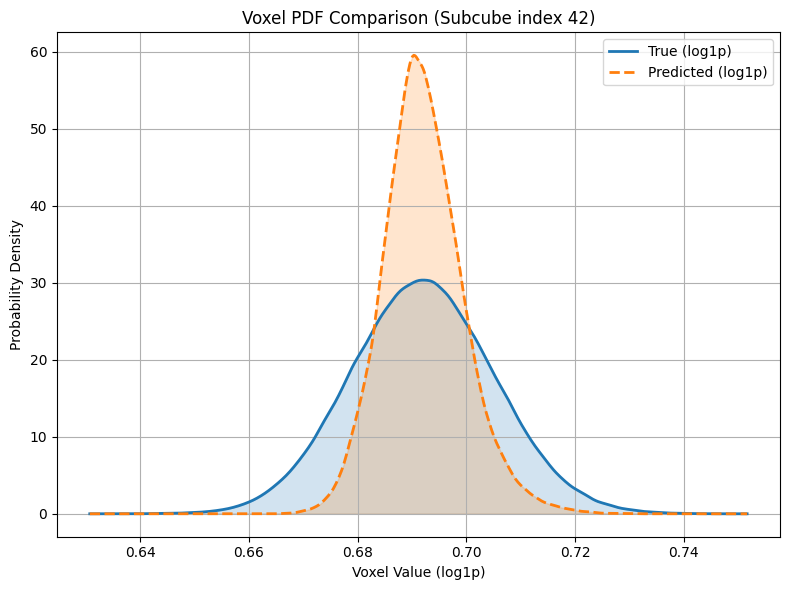

In [12]:
compare_voxel_pdf(
    y_true=gt_cube,
    y_pred=pred_cube,
    index=index,
    model_name=model_name,
    save_dir=eval_dir,
    log_transform=True,
    show=True
)
